# Sentinel-2 data in Python

- Khizer Zakir
- Learned from Lorena Abad
- 14-05-2025

## Accessing data via STAC API

Libraries needed for this exercise are imported below:

In [5]:
import geogif # render gifs from raster images
import geopandas as gpd # handle geospatial data frames
from IPython.display import Image # visualize URLs
import pandas as pd # data wrangling
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform resampling operations
import rioxarray # handle spatio-temporal arrays
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube

### Querying data with `pystac-client`

[STAC](https://stacspec.org/en) stands for SpatioTemporal Asset Catalog and it is "a common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered". 

[`pystac-client`](https://pystac-client.readthedocs.io/en/stable/quickstart.html#python) allows the querying of a STAC API using Python.

There are several APIs available to query data, you can browse them all in the [STAC catalog index](https://stacindex.org/catalogs). Some of these APIs will require authentication to access the data. We will use the [Earth Search](https://www.element84.com/earth-search/) catalog for this notebook, which allows querying data on Amazon Web Services (AWS). The data we will fetch does not require authentication.

In [6]:
# STAC API URL 
api_url = 'https://earth-search.aws.element84.com/v1'

To start fetching data, we will open the client. We can see the collections available for this API:

In [7]:
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


Let's focus on Sentinel-2 data level 2a. [Here are the different levels that Sentinel-2 has](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels). Level 2a provides atmospherically corrected data representing surface reflectance.

In [8]:
# collection ID
collection = 'sentinel-2-l2a'

Let's define now the spatial and temporal extent for our query. We will query all scenes intersecting the point coordinates and the time range given. 

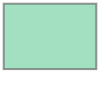

In [ ]:
# Senegal bounding box coordinates (lon_min, lat_min, lon_max, lat_max)
lon_min, lat_min, lon_max, lat_max = -17.819824, 12.105957, -11.315918, 16.700164
# create a bounding box
bbox = shapely.box(lon_min, lat_min, lon_max, lat_max)
datetime = '2022-05-01/2022-10-01'
bbox


And we pass these arguments to our search:

In [11]:
search = client.search(
    collections=[collection],
    bbox=bbox.bounds,
    datetime=datetime
    # query=["eo:cloud_cover<10"],
)

In [12]:
items = search.item_collection()
len(items)

2363

We can view our query as a Geopandas data frame for easier readability:

In [13]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,created,platform,constellation,instruments,eo:cloud_cover,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,grid:code,...,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,proj:code,s2:mgrs_tile
0,"POLYGON ((-16.42478 12.66073, -15.83066 12.663...",2022-11-06T12:09:36.658Z,sentinel-2b,sentinel-2,[msi],82.954568,28,P,CU,MGRS-28PCU,...,0.996159,2022-10-01T11:38:10.413000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/C...,roda-sentinel2/workflow-sentinel2-to-stac/4446...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T12:09:36.658Z,EPSG:32628,NaN
1,"POLYGON ((-15.92125 12.66295, -14.91013 12.664...",2022-11-06T12:38:10.094Z,sentinel-2b,sentinel-2,[msi],48.157033,28,P,DU,MGRS-28PDU,...,0.996159,2022-10-01T11:38:07.309000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/D...,roda-sentinel2/workflow-sentinel2-to-stac/bbca...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T12:38:10.094Z,EPSG:32628,NaN
2,"POLYGON ((-15.00017 12.66454, -13.98906 12.662...",2022-11-05T22:04:41.139Z,sentinel-2b,sentinel-2,[msi],55.054426,28,P,EU,MGRS-28PEU,...,0.996159,2022-10-01T11:38:03.938000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/E...,roda-sentinel2/workflow-sentinel2-to-stac/c9a7...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-05T22:04:41.139Z,EPSG:32628,28PEU
3,"POLYGON ((-14.0791 12.66295, -13.66462 12.6611...",2022-11-06T03:54:03.104Z,sentinel-2b,sentinel-2,[msi],66.139889,28,P,FU,MGRS-28PFU,...,0.996159,2022-10-01T11:38:00.038000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/F...,roda-sentinel2/workflow-sentinel2-to-stac/9be1...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:54:03.104Z,EPSG:32628,NaN
4,"POLYGON ((-16.22356 13.56544, -15.8337 13.5670...",2022-11-06T12:09:51.546Z,sentinel-2b,sentinel-2,[msi],39.254251,28,P,CV,MGRS-28PCV,...,0.996159,2022-10-01T11:37:55.534000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/C...,roda-sentinel2/workflow-sentinel2-to-stac/9b62...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T12:09:51.546Z,EPSG:32628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,"POLYGON ((-12.19348 16.26221, -11.16769 16.246...",2022-11-06T03:57:54.043Z,sentinel-2b,sentinel-2,[msi],0.000113,28,P,HC,MGRS-28PHC,...,0.987265,2022-05-01T11:26:56.080000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/H...,roda-sentinel2/workflow-sentinel2-to-stac/6f08...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:57:54.043Z,EPSG:32628,NaN
2359,"POLYGON ((-11.80687 16.26221, -10.7801 16.2733...",2022-11-06T03:31:17.014Z,sentinel-2b,sentinel-2,[msi],0.000179,29,P,KT,MGRS-29PKT,...,0.987265,2022-05-01T11:26:54.322000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/P/K...,roda-sentinel2/workflow-sentinel2-to-stac/aa20...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:31:17.014Z,EPSG:32629,NaN
2360,"POLYGON ((-12.88461 17.17389, -12.08841 17.163...",2022-11-03T18:26:45.794Z,sentinel-2b,sentinel-2,[msi],2.421968,28,Q,GD,MGRS-28QGD,...,0.987265,2022-05-01T11:26:44.425000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/Q/G...,roda-sentinel2/workflow-sentinel2-to-stac/03a1...,False,{'sentinel2-to-stac': '0.1.0'},2022-11-06T12:47:14.123Z,EPSG:32628,NaN
2361,"POLYGON ((-12.18024 17.16528, -11.14963 17.148...",2022-11-05T20:12:24.538Z,sentinel-2b,sentinel-2,[msi],0.651965,28,Q,HD,MGRS-28QHD,...,0.987265,2022-05-01T11:26:41.391000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/Q/H...,roda-sentinel2/workflow-sentinel2-to-stac/c9b0...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-05T20:12:24.538Z,EPSG:32628,28QHD


This proves useful for example when we want to visualize the cloud cover of our whole collection:

<Axes: title={'center': 'eo:cloud-cover'}, xlabel='datetime'>

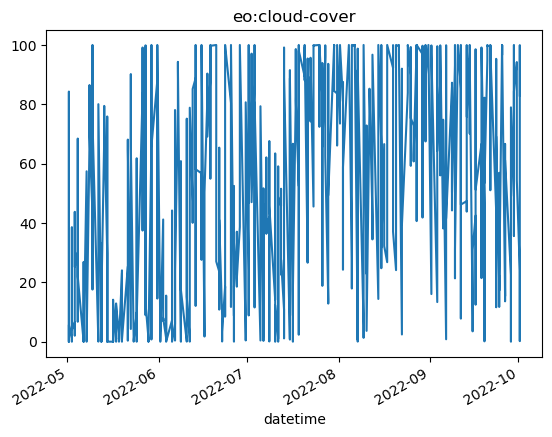

In [16]:
df["datetime"] = pd.to_datetime(df["datetime"], format='ISO8601')

ts = df.set_index("datetime").sort_index()["eo:cloud_cover"]
ts.plot(title="eo:cloud-cover")

Let's explore the properties of one item. But first let's look for an item index with low cloud cover and low nodata.

In [17]:
df_filt = df.loc[(df['eo:cloud_cover'] <= 2) & (df['s2:nodata_pixel_percentage'] <= 10)]
df_filt

,geometry,created,platform,constellation,instruments,eo:cloud_cover,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,grid:code,...,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,proj:code,s2:mgrs_tile
62,"POLYGON ((-12.21754 14.45637, -11.2005 14.4421...",2022-11-06T03:57:31.568Z,sentinel-2b,sentinel-2,[msi],1.670635,28,P,HA,MGRS-28PHA,...,0.994456,2022-09-28 11:27:31.044000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/H...,roda-sentinel2/workflow-sentinel2-to-stac/8549...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:57:31.568Z,EPSG:32628,NaN
63,"POLYGON ((-11.78281 14.45637, -10.76483 14.466...",2022-11-06T03:30:54.983Z,sentinel-2b,sentinel-2,[msi],1.979596,29,P,KR,MGRS-29PKR,...,0.994456,2022-09-28 11:27:28.835000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/P/K...,roda-sentinel2/workflow-sentinel2-to-stac/8cff...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:30:54.983Z,EPSG:32629,NaN
66,"POLYGON ((-12.20591 15.3596, -11.18463 15.3444...",2022-11-06T03:58:04.852Z,sentinel-2b,sentinel-2,[msi],1.044864,28,P,HB,MGRS-28PHB,...,0.994456,2022-09-28 11:27:16.428000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/H...,roda-sentinel2/workflow-sentinel2-to-stac/82ff...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:58:04.852Z,EPSG:32628,NaN
69,"POLYGON ((-13.09967 16.27229, -12.10208 16.260...",2022-11-06T03:36:14.250Z,sentinel-2b,sentinel-2,[msi],1.621981,28,P,GC,MGRS-28PGC,...,0.994456,2022-09-28 11:27:04.965000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/fe3e...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:36:14.250Z,EPSG:32628,NaN
70,"POLYGON ((-12.19348 16.26221, -11.16769 16.246...",2022-11-06T03:57:34.521Z,sentinel-2b,sentinel-2,[msi],1.407925,28,P,HC,MGRS-28PHC,...,0.994456,2022-09-28 11:27:02.092000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/H...,roda-sentinel2/workflow-sentinel2-to-stac/55a8...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:57:34.521Z,EPSG:32628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,"POLYGON ((-13.08901 16.2722, -12.10208 16.2609...",2022-11-06T03:35:51.674Z,sentinel-2b,sentinel-2,[msi],0.043366,28,P,GC,MGRS-28PGC,...,0.987265,2022-05-01 11:26:58.957000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/9473...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:35:51.674Z,EPSG:32628,NaN
2358,"POLYGON ((-12.19348 16.26221, -11.16769 16.246...",2022-11-06T03:57:54.043Z,sentinel-2b,sentinel-2,[msi],0.000113,28,P,HC,MGRS-28PHC,...,0.987265,2022-05-01 11:26:56.080000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/P/H...,roda-sentinel2/workflow-sentinel2-to-stac/6f08...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:57:54.043Z,EPSG:32628,NaN
2359,"POLYGON ((-11.80687 16.26221, -10.7801 16.2733...",2022-11-06T03:31:17.014Z,sentinel-2b,sentinel-2,[msi],0.000179,29,P,KT,MGRS-29PKT,...,0.987265,2022-05-01 11:26:54.322000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/P/K...,roda-sentinel2/workflow-sentinel2-to-stac/aa20...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-06T03:31:17.014Z,EPSG:32629,NaN
2361,"POLYGON ((-12.18024 17.16528, -11.14963 17.148...",2022-11-05T20:12:24.538Z,sentinel-2b,sentinel-2,[msi],0.651965,28,Q,HD,MGRS-28QHD,...,0.987265,2022-05-01 11:26:41.391000+00:00,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/Q/H...,roda-sentinel2/workflow-sentinel2-to-stac/c9b0...,True,{'sentinel2-to-stac': '0.1.0'},2022-11-05T20:12:24.538Z,EPSG:32628,28QHD


In [18]:
item = items[df_filt.index[0]]
item.geometry

{'type': 'Polygon',
 'coordinates': [[[-12.217544600236915, 14.456370371812048],
   [-11.20050128141882, 14.442149490825521],
   [-11.216702236019096, 13.45153788437235],
   [-12.229424961452263, 13.46474654274506],
   [-12.217544600236915, 14.456370371812048]]]}

In [19]:
item.datetime

datetime.datetime(2022, 9, 28, 11, 27, 31, 44000, tzinfo=tzutc())

In [20]:
item.properties

{'created': '2022-11-06T03:57:31.568Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 1.670635,
 'mgrs:utm_zone': 28,
 'mgrs:latitude_band': 'P',
 'mgrs:grid_square': 'HA',
 'grid:code': 'MGRS-28PHA',
 'view:sun_azimuth': 131.484709283168,
 'view:sun_elevation': 66.3516539366712,
 's2:degraded_msi_data_percentage': 0.0129,
 's2:nodata_pixel_percentage': 0,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 0.00435,
 's2:cloud_shadow_percentage': 0.377368,
 's2:vegetation_percentage': 95.064265,
 's2:not_vegetated_percentage': 2.591252,
 's2:water_percentage': 0.265766,
 's2:unclassified_percentage': 0.026367,
 's2:medium_proba_clouds_percentage': 0.228566,
 's2:high_proba_clouds_percentage': 0.05141,
 's2:thin_cirrus_percentage': 1.390659,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '04.00',
 's2:product_uri': 'S2B_MSIL2A_20220928T110739_N0400_R137_T28PHA_20

We can also take a look at the assets for the item. That is which bands are available. 

In [21]:
item.assets.keys()

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])

And we can also preview how this scene looks like:

In [22]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

Let's take a look at one single band:

In [23]:
asset = item.assets["red"]

In [24]:
asset.extra_fields

{'eo:bands': [{'name': 'red',
   'common_name': 'red',
   'description': 'Red (band 4)',
   'center_wavelength': 0.665,
   'full_width_half_max': 0.038}],
 'gsd': 10,
 'proj:shape': [10980, 10980],
 'proj:transform': [10, 0, 799980, 0, -10, 1600020],
 'raster:bands': [{'nodata': 0,
   'data_type': 'uint16',
   'bits_per_sample': 15,
   'spatial_resolution': 10,
   'scale': 0.0001,
   'offset': -0.1}]}

And read it with [`rioxarray`](https://corteva.github.io/rioxarray/stable/).

In [25]:
red = rioxarray.open_rasterio(item.assets["red"].href, decode_coords="all")

We can now plot the data, in this case a subset to speed up the process. That is achieved with the `isel()` function.

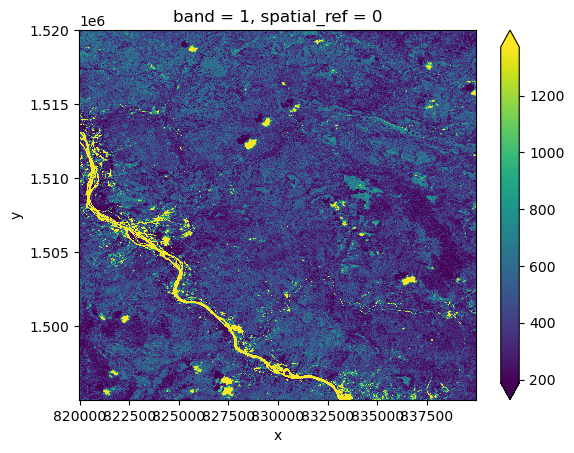

In [26]:
red.isel(x=slice(2000, 4000), y=slice(8000, 10500)).plot(robust=True)

What about an RGB representation?

In [27]:
rgb = rioxarray.open_rasterio(item.assets["visual"].href)

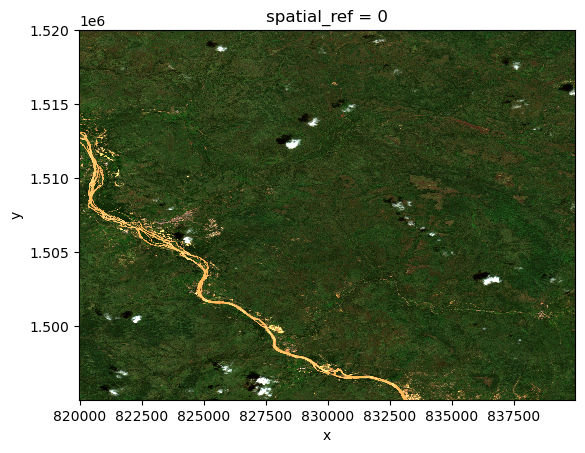

In [28]:
rgb.isel(x=slice(2000, 4000), y=slice(8000, 10500)).plot.imshow()

### Creating a STAC data cube

To work with the STAC items as a data cube we can use the [`stackstac`](https://stackstac.readthedocs.io/en/latest/) package. 

To limit our data cube size we will create it only focused on the Poznan bounding box.

In [29]:
footprint = gpd.read_file("map.geojson")
footprint.total_bounds

array([-16.6339308 ,  13.84298979, -15.65230999,  14.72825687])

In [35]:
# Desired band names you want to keep
desired_bands = {
    'aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09',
    'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22'
}

# Filter each item to retain only desired bands
filtered_items = []
for item in items:
    filtered_assets = {
        band: asset for band, asset in item.assets.items()
        if band in desired_bands
    }
    # Only keep the item if it has at least one matching band
    if filtered_assets:
        item.assets = filtered_assets
        filtered_items.append(item)

filtered_items

[<Item id=S2B_28PCU_20221001_0_L2A>,
 <Item id=S2B_28PDU_20221001_0_L2A>,
 <Item id=S2B_28PEU_20221001_0_L2A>,
 <Item id=S2B_28PFU_20221001_0_L2A>,
 <Item id=S2B_28PCV_20221001_0_L2A>,
 <Item id=S2B_28PDV_20221001_0_L2A>,
 <Item id=S2B_28PEV_20221001_0_L2A>,
 <Item id=S2B_28PFV_20221001_0_L2A>,
 <Item id=S2B_28PCA_20221001_0_L2A>,
 <Item id=S2B_28PDA_20221001_0_L2A>,
 <Item id=S2B_28PEA_20221001_0_L2A>,
 <Item id=S2B_28PFA_20221001_0_L2A>,
 <Item id=S2B_28PCB_20221001_0_L2A>,
 <Item id=S2B_28PDB_20221001_0_L2A>,
 <Item id=S2B_28PEB_20221001_0_L2A>,
 <Item id=S2B_28PFB_20221001_0_L2A>,
 <Item id=S2B_28PDC_20221001_0_L2A>,
 <Item id=S2B_28PGB_20221001_0_L2A>,
 <Item id=S2B_28PEC_20221001_0_L2A>,
 <Item id=S2B_28PFC_20221001_0_L2A>,
 <Item id=S2B_28PGC_20221001_0_L2A>,
 <Item id=S2B_28QDD_20221001_0_L2A>,
 <Item id=S2B_28QED_20221001_0_L2A>,
 <Item id=S2B_28QFD_20221001_0_L2A>,
 <Item id=S2B_28QGD_20221001_0_L2A>,
 <Item id=S2A_28PHU_20220930_0_L2A>,
 <Item id=S2A_29PKP_20220930_0_L2A>,
 

In [36]:
cube = stackstac.stack(
    filtered_items,
    resolution=100,
    bounds_latlon=footprint.total_bounds,
    resampling=Resampling.bilinear,
    epsg = 32628
)
cube

<xarray.DataArray 'stackstac-4b88ae73a95a1114517187d1e007c511' (time: 251,
                                                                band: 14,
                                                                y: 986, x: 1064)> Size: 29GB
dask.array<fetch_raster_window, shape=(251, 14, 986, 1064), dtype=float64, chunksize=(1, 1, 986, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2kB 2022-0...
    id                                       (time) <U24 24kB 'S2A_28PDB_2022...
  * band                                     (band) <U8 448B 'aot' ... 'swir22'
  * x                                        (x) float64 9kB 3.234e+05 ... 4....
  * y                                        (y) float64 8kB 1.629e+06 ... 1....
    earthsearch:s3_path                      (time) <U80 80kB 's3://sentinel-...
    ...                                       ...
    raster:bands                             (band) object 112B {'nodata': 0,...
    gsd                                      (band) object 112B None 10 ... 20
    common_name                              (band) object 112B None ... 'swi...
    center_wavelength                        (band) object 112B None ... 2.19
    full_width_half_max                      (band) object 112B None ... 0.242
    epsg                                     int32 4B 32628
Attributes:
    spec:        RasterSpec(epsg=32628, bounds=(323400, 1530400, 429800, 1629...
    crs:         epsg:32628
    transform:   | 100.00, 0.00, 323400.00|\n| 0.00,-100.00, 1629000.00|\n| 0...
    resolution:  100

We can further wrangle this cube by selecting only RGB bands and creating monthly composites. We can achieve this with `xarray` resample. This are all the [time range formats](https://docs.xarray.dev/en/latest/generated/xarray.cftime_range.html) supported. 

In [ ]:
rgb = cube.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [ ]:
monthly

We will use the `compute()` function from [`dask`](https://docs.dask.org/en/stable/) to read our object in-memory. 

In [ ]:
monthly = monthly.compute()

This will make plotting tasks faster.

In [ ]:
monthly.plot.imshow(
    col="time",
    col_wrap=3,
    rgb="band",
    robust=True,
    size=4,
    add_labels=False,
)

We can work on derived calculation, for example, we can compute the NDVI per scene

In [37]:
nir, red = cube.sel(band="nir"), cube.sel(band="red")
ndvi = (nir - red) / (nir + red)

In [38]:
ndvi

<xarray.DataArray 'stackstac-4b88ae73a95a1114517187d1e007c511' (time: 251,
                                                                y: 986, x: 1064)> Size: 2GB
dask.array<truediv, shape=(251, 986, 1064), dtype=float64, chunksize=(1, 986, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 2kB 2022-0...
    id                                       (time) <U24 24kB 'S2A_28PDB_2022...
  * x                                        (x) float64 9kB 3.234e+05 ... 4....
  * y                                        (y) float64 8kB 1.629e+06 ... 1....
    earthsearch:s3_path                      (time) <U80 80kB 's3://sentinel-...
    view:sun_azimuth                         (time) float64 2kB 85.74 ... 130.6
    ...                                       ...
    mgrs:utm_zone                            int32 4B 28
    created                                  (time) <U24 24kB '2022-11-06T12:...
    s2:mgrs_tile                             (time) object 2kB None ... None
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    gsd                                      object 8B 10
    epsg                                     int32 4B 32628

Let's create a composite with the maximum NDVI value for the whole collection over time.

In [39]:
ndvi_comp = ndvi.max("time")

In [40]:
ndvi_comp

<xarray.DataArray 'stackstac-4b88ae73a95a1114517187d1e007c511' (y: 986, x: 1064)> Size: 8MB
dask.array<_nanmax_skip-aggregate, shape=(986, 1064), dtype=float64, chunksize=(986, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * x                                        (x) float64 9kB 3.234e+05 ... 4....
  * y                                        (y) float64 8kB 1.629e+06 ... 1....
    processing:software                      object 8B {'sentinel2-to-stac': ...
    constellation                            <U10 40B 'sentinel-2'
    s2:snow_ice_percentage                   int32 4B 0
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'P'
    mgrs:utm_zone                            int32 4B 28
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    gsd                                      object 8B 10
    epsg                                     int32 4B 32628

In [ ]:
ndvi_comp = ndvi_comp.compute()

C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


KeyboardInterrupt: 

C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
C:\Users\Khizer Zakir\AppData\Roaming\Python\Python312\site-packages\dask\_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [42]:
ndvi_comp.plot(vmin=0, vmax=0.8, cmap="YlGn")

KeyboardInterrupt: 

And finally, let's compute the NDVI anomaly, i.e., how much does each pixel from the composite deviates from the mean of the whole collection.

In [ ]:
anomaly = ndvi_comp - ndvi.mean()

In [ ]:
anomaly = anomaly.compute()

In [ ]:
anomaly.plot(cmap="PiYG")

### Downloading the data

There might be at some point the need to download the scenes that you just queried. To do so you can use the `os` and `urllib` modules that are part of the python standard library as the code snippet below shows. This will download all of the items from your search, so make sure you apply enough filtering so that you don't download data that you don't need.

``` python
download_path = "path/to/dir"

for item in items:
    download_path = os.path.join(item.collection_id, item.id)
    if not os.path.exists(download_path):
        os.makedirs(download_path, exist_ok=True)
    for name, asset in item.assets.items():
        urllib.request.urlretrieve(asset.href, 
                                   os.path.join(download_path, 
                                   os.path.basename(asset.href)))
```

## Exercises

1. Adjust your STAC query accordingly and create a new data cube **grouped by season**. Think about data sizes and play with an AOI of your choice.
2. Compute a time series of NDVI values for one crop parcel of your choice. *Hint:* you can easily create a geojson polygon with https://geojson.io/. Take the temporal grouping of your choice, but what would make sense to compare such vegetation values?

## More resources

This material was based on the Carpentries introduction to [Geospatial RAster and Vector data in Python](https://carpentries-incubator.github.io/geospatial-python/) and the [EGU23 short course on the same topic by Francesco Nattino and Ou Ku](https://github.com/esciencecenter-digital-skills/2023-04-25-ds-geospatial-python-EGU/tree/main).